# Global and Local Explanation for DNN model on MIT data

Input files:  
Mode: `model_mit_dnn.pkl` generated in notebook `modeling_mit_DNN.ipynb`     

Dataset: Binary classification datate genereted in notebook `preprocessing_mit_minmax_oversampling.ipynb`  
'mitbih_train_clean_minmax_oversampling.csv'  
'mitbih_test_clean_minmax_oversamling.csv'    

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: /Users/pingyuan/Documents/codeself/heartbeat-analysis-ai/notebooks


In [2]:
# Verify installation and import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
import pickle
from sklearn.model_selection import train_test_split
import os
import shap
import lime
import lime.lime_tabular

In [3]:
RawFiles = dict({
    'train': data_path + 'mitbih_train_clean_minmax_oversampling.csv', 
    'test': data_path + 'mitbih_test_clean_minmax_oversampling.csv'  
})


train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)

load model

In [4]:
# Define model_path based on model_output_path
model_path = model_output_path + 'model_mit_dnn.pkl'

# Load the DNN model from the pickle file
with open(model_path, 'rb') as file:
    dnn_model = pickle.load(file)

# Check the type of the model (Sequential)
print(f"Model type: {type(dnn_model)}")

# Print the summary of the DNN model to understand its architecture
dnn_model.summary()



AttributeError: 'Adamax' object has no attribute 'build'

### In the following we apply explanation strategies (SHAP, LIME) on the resampled (Oversampling) and rescaled (MinMax Scaler) dataset to explain the most important features within the KNN model due to to given strategies:

## SHAP Values

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


Shape of shap_values: (20284, 187, 1)
Shape of mean_shap_values after flattening: (187,)
Number of features in X_test.columns: 187
Top 10 most important features based on SHAP values:
    feature  importance
0      c_0    0.048811
3      c_3    0.037246
2      c_2    0.027560
13    c_13    0.019683
39    c_39    0.019616
26    c_26    0.019390
6      c_6    0.019377
54    c_54    0.016334
30    c_30    0.016283
31    c_31    0.016075


C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_468\1857590059.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


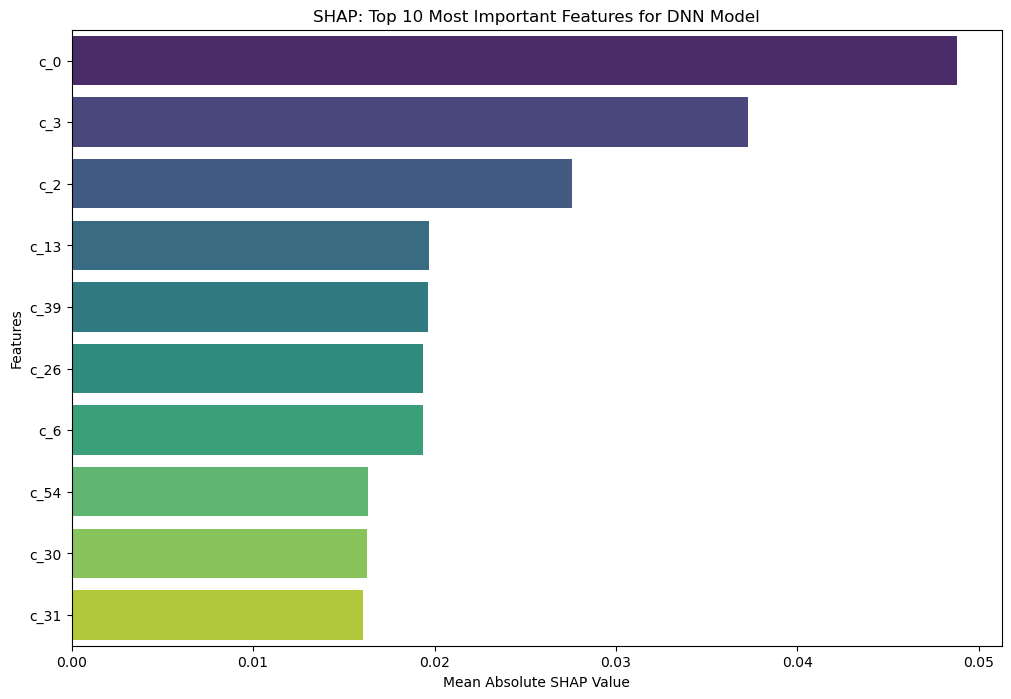

In [14]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample background data from training data
background_data = X_train.sample(100, random_state=42)  # Adjust sample size if needed

# Initialize the SHAP DeepExplainer
explainer = shap.DeepExplainer(pipeline_model, background_data.values)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test.values)

# If shap_values is a list select the first array
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Print shape of shap_values for debugging
print("Shape of shap_values:", shap_values.shape)  # Should be (num_samples, num_features)

# Calculate the mean absolute SHAP values across all test samples for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Ensure mean_shap_values is 1-dimensional
mean_shap_values = mean_shap_values.flatten()

# Confirm that mean_shap_values has the correct length
print("Shape of mean_shap_values after flattening:", mean_shap_values.shape)
print("Number of features in X_test.columns:", len(X_test.columns))

# Check that mean_shap_values matches the number of features in X_test.columns
if mean_shap_values.shape[0] != len(X_test.columns):
    print(f"Error: mean_shap_values length ({mean_shap_values.shape[0]}) does not match number of features ({len(X_test.columns)})")
else:
    # Create DataFrame for feature importance based on SHAP values
    shap_importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': mean_shap_values
    })

    # Sort by importance
    shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False)

    # Display the top 10 most important features based on SHAP values
    top_10_shap_features = shap_importance_df.head(10)
    print("Top 10 most important features based on SHAP values:\n", top_10_shap_features)

    # Plot the top 10 most important features
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='importance', 
        y='feature', 
        data=top_10_shap_features, 
        palette='viridis'
    )
    plt.title('SHAP: Top 10 Most Important Features for DNN Model')
    plt.xlabel('Mean Absolute SHAP Value')
    plt.ylabel('Features')
    plt.show()



c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


<Figure size 1200x800 with 0 Axes>

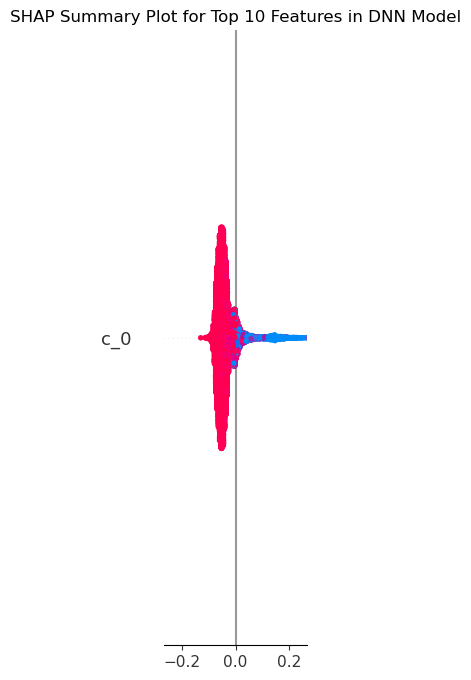

In [15]:
# feature  importance
explainer = shap.DeepExplainer(pipeline_model, background_data.values)
shap_values = explainer.shap_values(X_test.values)

# Get the top 10 feature names based on importance from the SHAP DataFrame
top_10_feature_names = top_10_shap_features['feature'].values

# Find the indices of the top 10 features in the original dataset
top_10_feature_indices = [X_test.columns.get_loc(feature) for feature in top_10_feature_names]

# Subset the X_test data to only include the top 10 features
X_test_top_10 = X_test[top_10_feature_names]

# Subset the SHAP values for the top 10 features
shap_values_top_10 = shap_values[:, top_10_feature_indices]

# Plot the SHAP summary plot for the top 10 features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_top_10, X_test_top_10, show=False)  # Use `show=False` to modify plot before displaying
plt.title('SHAP Summary Plot for Top 10 Features in DNN Model')
plt.show()


## LIME


True Label for selected instance: 0
Instance features:
 c_0      0.980392
c_1      0.696078
c_2      0.193627
c_3      0.009804
c_4      0.061275
           ...   
c_182    0.000000
c_183    0.000000
c_184    0.000000
c_185    0.000000
c_186    0.000000
Name: 200, Length: 187, dtype: float64


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

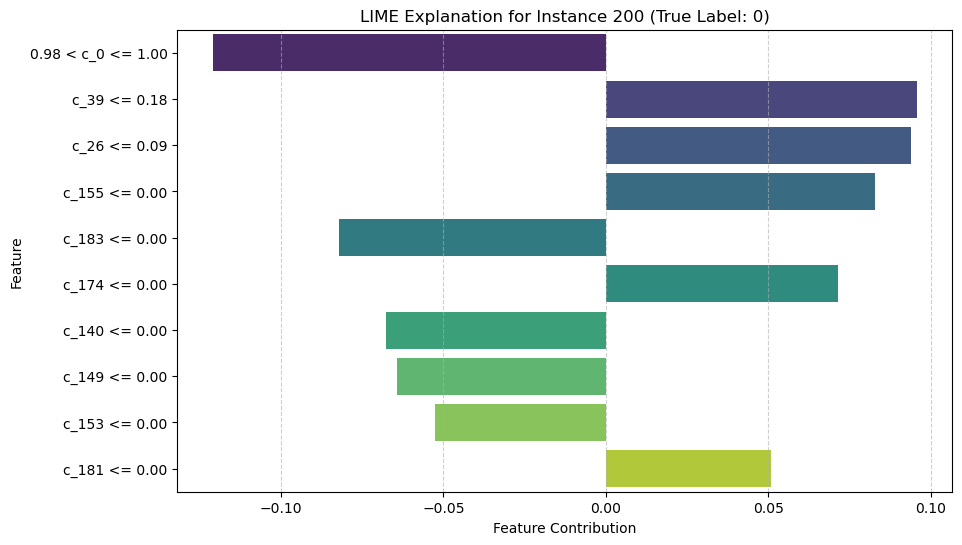

In [16]:
# Wrapper function for predict_proba behavior
def predict_proba_wrapper(data):
    # Predict using the model (outputs probabilities for binary classification)
    predictions = pipeline_model.predict(data)
    # Reshape predictions to have two columns for binary classification: [1 - prediction, prediction]
    return np.column_stack([1 - predictions, predictions])

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Features from the training data
    training_labels=np.array(y_train),  # Target labels for training data
    mode="classification",  # Set to 'classification' for binary classification
    feature_names=X_train.columns,  # Feature names
    class_names=['Class 0', 'Class 1'],  # Class names for binary classification
    discretize_continuous=True  # Discretizes continuous features
)

# Select a random instance from the test set
idx = 200  # You can change this index to select a different instance
instance = X_test.iloc[idx]  # The input instance
true_label = y_test.iloc[idx]

print("True Label for selected instance:", true_label)
print("Instance features:\n", instance)

# Explain the instance using the LIME explainer
exp = explainer.explain_instance(
    data_row=instance,  # Instance to explain
    predict_fn=predict_proba_wrapper,  # Use the wrapper function here
    num_features=10  # Number of features to include in the explanation
)

# Extract feature contributions from the explanation object
feature_importance = exp.as_list()  # Returns a list of (feature, contribution) tuples

# Convert the feature importance to a DataFrame for easy visualization
lime_df = pd.DataFrame(feature_importance, columns=['Feature', 'Contribution'])

# Plot the LIME explanation using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Contribution', 
    y='Feature', 
    data=lime_df, 
    palette='viridis', 
    orient='h'
)
plt.title(f'LIME Explanation for Instance {idx} (True Label: {true_label})')
plt.xlabel('Feature Contribution')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [1]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-11-05 10:59:11.799186
